# Non maximum suppression speed test

Source: https://gist.github.com/PREM1980/93ec1298bea0495feaae77c798a345f0
Source 2: https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/

In [52]:
import numpy as np
import cv2
import datetime
import numpy as np

boxes = np.array([
        (12, 84, 140, 236),
        (24, 85, 152, 213),
        (36, 86, 164, 211),
        (36, 86, 164, 211),
        (35, 86, 162, 210),
        (31, 86, 161, 211),
        (35, 86, 162, 210),
        (31, 87, 165, 210),
        (35, 86, 162, 211),
        (12, 96, 140, 224),
        (24, 96, 152, 225),
        (24, 96, 152, 223),
        (24, 96, 152, 227),
        (24, 96, 152, 221),
        (24, 96, 152, 229),
        (25, 96, 153, 224),
        (27, 96, 154, 224),
        (28, 96, 155, 224),
        (26, 96, 152, 224),
        (25, 108, 152, 212)])


#  Felzenszwalb et al.
def non_max_suppression_slow(boxes, overlapThresh):
        # print boxes
        # if there are no boxes, return an empty list
        if len(boxes) == 0:
                return []

        # initialize the list of picked indexes
        pick = []

        # grab the coordinates of the bounding boxes
        # print boxes
        x1 = boxes[:,0]
        y1 = boxes[:,1]
        x2 = boxes[:,2]
        y2 = boxes[:,3]
        # compute the area of the bounding boxes and sort the bounding
        # boxes by the bottom-right y-coordinate of the bounding box
        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        # print 'area == ', area
        # print 'y2 == ', y2
        idxs = np.argsort(y2)
        # print 'idxs == ', idxs

        # keep looping while some indexes still remain in the indexes
        # list
        while len(idxs) > 0:
                # grab the last index in the indexes list, add the index
                # value to the list of picked indexes, then initialize
                # the suppression list (i.e. indexes that will be deleted)
                # using the last index
                last = len(idxs) - 1
                # print 'last == ', last
                i = idxs[last]
                pick.append(i)
                # print 'pick == ', pick
                suppress = [last]
                # print 'suppress == ', suppress

                # loop over all indexes in the indexes list
                for pos in range(0, last):
                        # grab the current index
                        j = idxs[pos]
                        # print 'i === ', i
                        # print 'j = ', j

                        # find the largest (x, y) coordinates for the start of
                        # the bounding box and the smallest (x, y) coordinates
                        # for the end of the bounding box
                        xx1 = max(x1[i], x1[j])
                        yy1 = max(y1[i], y1[j])
                        xx2 = min(x2[i], x2[j])
                        yy2 = min(y2[i], y2[j])

                        # compute the width and height of the bounding box
                        w = max(0, xx2 - xx1 + 1)
                        h = max(0, yy2 - yy1 + 1)

                        # compute the ratio of overlap between the computed
                        # bounding box and the bounding box in the area list
                        overlap = float(w * h) / area[j]

                        # if there is sufficient overlap, suppress the
                        # current bounding box
                        # print 'overlap == ', overlap
                        if overlap > overlapThresh:
                                suppress.append(pos)
                                # print 'suppress /== ', suppress

                # delete all indexes from the index list that are in the
                # suppression list
                idxs = np.delete(idxs, suppress)
                # print 'final idxs == ', idxs

        # return only the bounding boxes that were picked
        # print 'final pick == ', pick
        return boxes[pick]

# # import the necessary packages
# import numpy as np

# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
        # if there are no boxes, return an empty list
        if len(boxes) == 0:
                return []

        # if the bounding boxes integers, convert them to floats --
        # this is important since we'll be doing a bunch of divisions
        # print boxes.dtype.kind
        if boxes.dtype.kind == "i":
                boxes = boxes.astype("float")

        # initialize the list of picked indexes
        pick = []

        # grab the coordinates of the bounding boxes
        x1 = boxes[:,0]
        y1 = boxes[:,1]
        x2 = boxes[:,2]
        y2 = boxes[:,3]

        # compute the area of the bounding boxes and sort the bounding
        # boxes by the bottom-right y-coordinate of the bounding box
        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        # print area

        idxs = np.argsort(area)
        # print idxs

        # keep looping while some indexes still remain in the indexes
        # list
        while len(idxs) > 0:
                # grab the last index in the indexes list and add the
                # index value to the list of picked indexes
                # print 'hello'
                last = len(idxs) - 1
                i = idxs[last]
                pick.append(i)

                # find the largest (x, y) coordinates for the start of
                # the bounding box and the smallest (x, y) coordinates
                # for the end of the bounding box
                xx1 = np.maximum(x1[i], x1[idxs[:last]])
                yy1 = np.maximum(y1[i], y1[idxs[:last]])
                xx2 = np.minimum(x2[i], x2[idxs[:last]])
                yy2 = np.minimum(y2[i], y2[idxs[:last]])

                # compute the width and height of the bounding box
                w = np.maximum(0, xx2 - xx1 + 1)
                h = np.maximum(0, yy2 - yy1 + 1)

                # compute the ratio of overlap
                overlap = (w * h) / area[idxs[:last]]

                # delete all indexes from the index list that have
                idxs = np.delete(idxs, np.concatenate(
                                                (
                                                [last],
                                                np.where(overlap > overlapThresh)[0]
                                                )
                                                )
                                        )


        # return only the bounding boxes that were picked using the
        # integer data type
        return boxes[pick].astype("int")        
        # return boxes[pick]






In [54]:
x = []
slow_y, fast_y = [], []
all_boxes = np.array(boxes)
for i in range(50):
    all_boxes = np.concatenate((all_boxes, boxes))
    x.append(len(all_boxes))
    
    start = datetime.datetime.now()
    for _ in range(1000):
        pick = non_max_suppression_slow(all_boxes, 0.8)
    end = datetime.datetime.now()        
    delta = end - start
    slow_y.append(delta.total_seconds())
    
    start = datetime.datetime.now()
    for _ in range(1000):
        pick = non_max_suppression_fast(all_boxes, 0.8)
    end = datetime.datetime.now()        
    delta = end - start
    fast_y.append(delta.total_seconds())
    
    

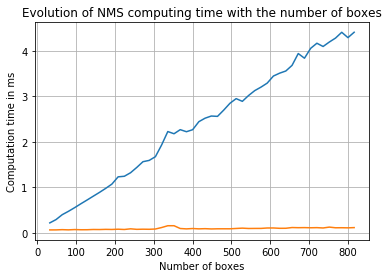

In [51]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots()
ax.plot(x, slow_y)
ax.plot(x, fast_y)

ax.set(xlabel='Number of boxes', ylabel='Computation time in ms',
       title='Evolution of NMS computing time with the number of boxes')
ax.grid()

plt.show()